In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import linear_model, svm
from sklearn.metrics import make_scorer, r2_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
#import tflearn
#import tensorflow as tf
import seaborn as sns
#import warnings
#warnings.filterwarnings('ignore')

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

In [88]:
# load dataset
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [89]:
# Save target variable 'SalePrice' to a list
sale_price = data['SalePrice']

# Drop the 'Id' and 'SalePrice'
data.drop(['Id', 'SalePrice'], axis = 1, inplace = True)


In [90]:
print(data.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


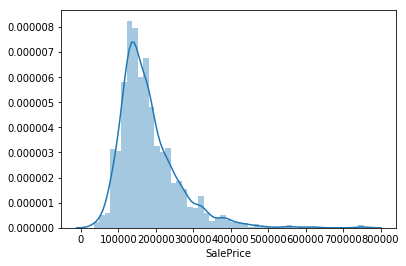

In [96]:
# normality check for the target
ax = sns.distplot(sale_price)
plt.show()

### Types of variables

Let's go ahead and find out what types of variables there are in this dataset

In [91]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

# let's visualise the values of the discrete variables
discrete = []
for var in numerical:
    if len(data[var].unique())<20:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

#find continuous variables
continuous = [var for var in numerical if var not in discrete]
print('There are {} continuous variables'.format(len(continuous)))

There are 43 categorical variables
There are 36 numerical variables
MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]
There are 15 discrete variables
There are 21 continuous variables


C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


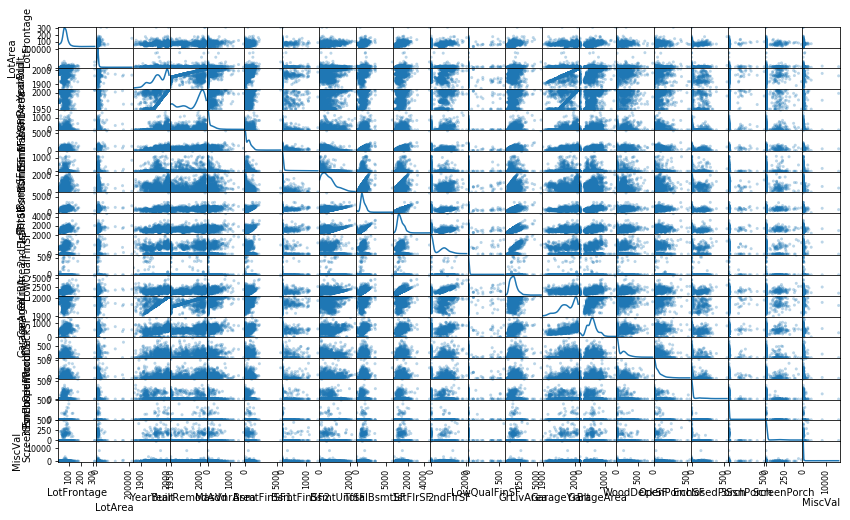

In [92]:
#Correlation map to see how features are correlated with SalePrice
pd.scatter_matrix(data[continuous], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Featureset Exploration
* MSSubClass: 1 to 14 in numerical format, but it should be considered as categorical variable.
* MSZoning: RL, RM, FV, RH and C.
* LotFrontage: continuous.
* LotArea: continuous.
* Street: Pave and Grvl.
* Alley: Pave and Grvl.
* LotShape: Reg, IR1, IR2 and IR3.
* LandContour: Lvl, Bnk, HLS and Low.
* Utilities: AllPub(1459) and NoSeWa(1)
* LotConfig: Inside, Corner, CulDSac, FR2 and FR3.
* LandSlope: Gtl, Mod and Sev.
* Neighborhood: NAmes, CollgCr, OldTown, etc. 
* Condition1: Norm, Feedr, Artery, etc.
* Condition2: Norm, Feedr, Artery, etc.
* BldgType: 1Fam, TwnhsE, Duplex, Twnhs and 2fmCon.
* HouseStyle: 1Story, 2Story, 1.5Fin, etc.
* OverallQual: 1 to 10 in numerical format, but it should be considered as categorical variable.
* OverallCond: 1 to 9 in numerical format, but it should be considered as categorical variable.
* YearBuilt: 
* YearRemodAdd: 
* RoofStyle: Gable, Hip, Flat, Gambrel, Mansard and Shed.
* RoofMatl: CompShg, Tar&Grv, WdShngl, etc.
* Exterior1st: VinylSd, HdBoard, MetalSd, etc.
* Exterior2nd: VinylSd, HdBoard, MetalSd, etc.
* MasVnrType: BrkFace, Stone and BrkCmn.
* MasVnrArea: continuous.
* ExterQual: TA, Gd, Ex and Fa.
* ExterCond: TA, Gd, Ex, Fa and Po.
* Foundation: PConc, CBlock, BrkTil, Slab, Stone and Wood.
* BsmtQual: TA, Gd, Ex and Fa.
* BsmtCond: TA, Gd, Fa and Po.
* BsmtExposure: No, Av, Gd and Mn.
* BsmtFinType1: Unf, GLQ, ALQ, BLQ, Rec and LwQ.
* BsmtFinSF1: continuous.
* BsmtFinType2: Unf, GLQ, ALQ, BLQ, Rec and LwQ.
* BsmtFinSF2: continuous.
* BsmtUnfSF: continuous.
* TotalBsmtSF: continuous.
* Heating: GasA, GasW, Grav, Wall, OthW and Floor.
* HeatingQC: Ex, TA, Gd, Fa and Po.
* CentralAir: Y and N.
* Electrical: SBrkr, FuseA, FuseF, FuseP and Mix.
* 1stFlrSF: continuous.
* 2ndFlrSF: continuous.
* LowQualFinSF: continuous.
* GrLivArea: continuous.
* BsmtFullBath: 0, 1, 2 and 3.
* BsmtHalfBath: 0, 1 and 2.
* FullBath: 0, 1, 2 and 3.
* HalfBath: 0, 1 and 2.
* BedroomAbvGr: 0 to 8.
* KitchenAbvGr: 0, 1, 2 and 3.
* KitchenQual: TA, Gd, Ex and Fa.
* TotRmsAbvGrd: 2 to 14.
* Functional: Typ, Min1, Min2, Mod, Maj1, Maj2 and Sev.
* Fireplaces: 0, 1, 2 and 3.
* FireplaceQu: Ex, TA, Gd, Fa and Po.
* GarageType: Attchd, Detchd, BuiltIn, Basment, CarPort and 2Types.
* GarageYrBlt: 
* GarageFinish: Unf, RFn and Fin.
* GarageCars: 0 to 4.
* GarageArea: continuous.
* GarageQual: Ex, TA, Gd, Fa and Po.
* GarageCond: Ex, TA, Gd, Fa and Po.
* PavedDrive: Y, N and P.
* WoodDeckSF: continuous.
* OpenPorchSF: continuous.
* EnclosedPorch: continuous.
* 3SsnPorch: continuous.
* ScreenPorch: continuous.
* PoolArea: continuous.
* PoolQC: Gd, Ex and Fa.
* Fence: MnPrv, GdPrv, GdWo and MnWw.
* MiscFeature: Shed, Gar2, Othr and TenC.
* MiscVal: continuous.
* MoSold: 1 to 12 month.
* YrSold: 
* SaleType: WD, New, COD, etc.
* SaleCondition: Normal, Partial, Abnorml, Family, Alloca and AdjLand.

In [93]:
nans = pd.isnull(data).sum()
nans[nans > 0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [46]:
# Remove id and columns with more than 500 missing values
data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1, inplace = True)

In [47]:
# Take a look 
data['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [48]:
# 
data.drop('Utilities', axis = 1, inplace = True)

In [49]:
nans = pd.isnull(data).sum()
nans[nans > 0].sort_values(ascending = False)

LotFrontage     259
GarageCond       81
GarageQual       81
GarageFinish     81
GarageYrBlt      81
GarageType       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
MasVnrType        8
Electrical        1
dtype: int64

In [50]:
# Count the column types
data.dtypes.value_counts()

object     37
int64      33
float64     3
dtype: int64

In [51]:
"""
LotFrontage: Since the area of each street connected to the house property
most likely have a similar area to other houses in its neighborhood,
we can fill in missing values by the median LotFrontage of the neighborhood.
"""
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [52]:
"""
Garage family: NaN means there is no garages, fill None in 
GarageCond: fill None
GarageQual: fill None
GarageFinish: fill None
GarageYrBlt: fill None
GarageType: fill None
"""
garage_features = ['GarageCond', 'GarageQual', 'GarageFinish', 'GarageYrBlt', 'GarageType']
for col in garage_features:
    data[col].fillna('None', inplace=True)

In [53]:
"""
Bsmt family: like garage family, fill None in NaN
BsmtFinType2
BsmtExposure
BsmtFinType1
BsmtCond
BsmtQual
"""
bsmt_features = ['BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']
for col in bsmt_features:
    data[col].fillna('None', inplace = True)

In [54]:
"""
MasVnrArea:fill the miss data with 0
MasVnrType: fill the miss data with None
Electrical: only 1 missing data, fill it with the most frequent
"""
data['MasVnrType'].fillna('None', inplace = True)
data['MasVnrArea'].fillna(0, inplace = True)
data['Electrical'].fillna(data['Electrical'].mode()[0], inplace = True)

In [55]:
all_columns = data.columns.values

numerical_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
                     'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
                      'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                     '3SsnPorch','ScreenPorch','PoolArea','MiscVal']

categorical_features = [value for value in all_columns if value not in numerical_features]

In [56]:
# One Hot Encoding and nan transformation
data = pd.get_dummies(data)

#imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
#data = imp.fit_transform(data)

# Log transformation
data = np.log(data)
labels = np.log(labels)

# Change -inf to 0 again
data[data == -np.inf] = 0

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [57]:
display(data.head(n=5))

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.094345,4.174387,9.041922,1.945910,1.609438,7.602401,7.602401,5.278115,6.559615,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.995732,4.382027,9.169518,1.791759,2.079442,7.588830,7.588830,0.000000,6.885510,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.094345,4.219508,9.328123,1.945910,1.609438,7.601402,7.601902,5.087596,6.186209,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.248495,4.094345,9.164296,1.945910,1.609438,7.557473,7.585789,0.000000,5.375278,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.094345,4.430817,9.565214,2.079442,1.609438,7.600902,7.600902,5.857933,6.484635,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Feature reduction
There are many features, so I am going to use PCA to reduce them. The idea is to start with n_components = number of columns. Then select the number of components that add up to 1 variance_ratio.

In [58]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([0.22420093, 0.40227021, 0.52594221, 0.62860595, 0.70145722,
       0.76072303, 0.81264591, 0.85674704, 0.88936649, 0.91979637,
       0.94549279, 0.95501863, 0.96414345, 0.97223698, 0.97966178,
       0.98474457, 0.9888668 , 0.99199506, 0.99402177, 0.99535956,
       0.99626787, 0.99708067, 0.99778539, 0.99846139, 0.99897314,
       0.99937473, 0.99961927, 0.99980251, 0.99988585, 0.99994289,
       0.99998741, 0.99999782, 0.99999931, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [60]:
pca = PCA(n_components=34,whiten=True)
pca = pca.fit(data)
dataPCA = pca.transform(data)
dataPCA.shape

(1460, 34)

In [73]:
"""
Benchmark: linear 

"""
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataPCA, labels, test_size=0.2, random_state=42)
clf = linear_model.LinearRegression()
#cv = KFold(n_splits = 5, shuffle = True, random_state = 45)
#r2 = make_scorer(r2_score)
#r2_val_score = cross_val_score(clf, data, labels, cv = cv, scoring = r2)
#scores=[r2_val_score.mean()]

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
score = r2_score(y_test, y_predict)
print(score)

0.882101887056052


Data Model Selection

Simple test to run multiple models against our data. First, with raw features. No PCA.

,R Square Score
Linear,0.853790
Ridge,0.838624
Bayesian Ridge,0.852442
Hubber,0.836427
Lasso,0.853935
Bagging,0.845202
RandomForest,0.844914
AdaBoost,0.796644
SVM RBF,0.812019
SVM Linear,0.849076


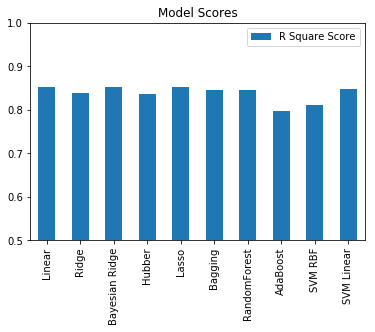

In [11]:
# R2 Score

def lets_try(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    #results=results.sort(columns=["R Square Score"],ascending=False)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results

lets_try(data,labels)

,R Square Score
Linear,0.853790
Ridge,0.853826
Bayesian Ridge,0.853915
Hubber,0.859652
Lasso,0.853833
Bagging,0.733012
RandomForest,0.725383
AdaBoost,0.669033
SVM RBF,0.791613
SVM Linear,0.858283


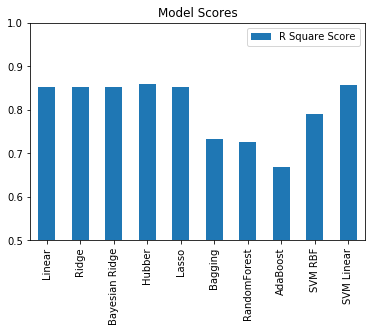

In [12]:
lets_try(dataPCA,labels)